# SWMM Precipitation Data Analysis

In this notebook we will run simulations using the NARR Daily and Hourly Precipitation Data and compare the results.

# 1) Imports

In [1]:
# General Usage
import glob
import pandas as pd
import os
import numpy as np

# Plotting
import matplotlib.pyplot as plt
import calendar

# Simulation
from pyswmm import Simulation
from swmmtoolbox import swmmtoolbox

# 2) Plots for Raw Hourly and Daily Data

In [49]:
date = [i for i in range(2920)]
xticks = [0,31,59,90,120,151,181,212,243,273,304,334]
xticks = [i * 8 for i in xticks]

## Hourly Data

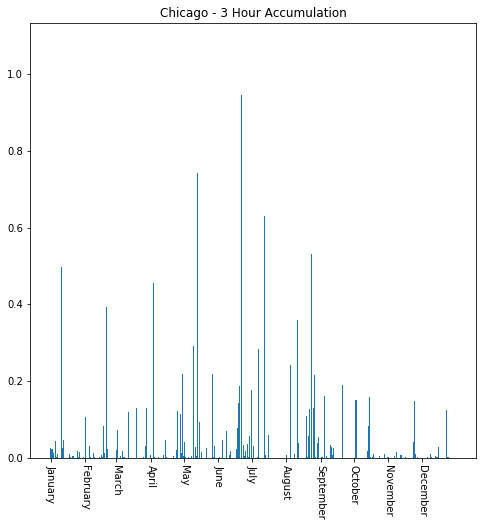

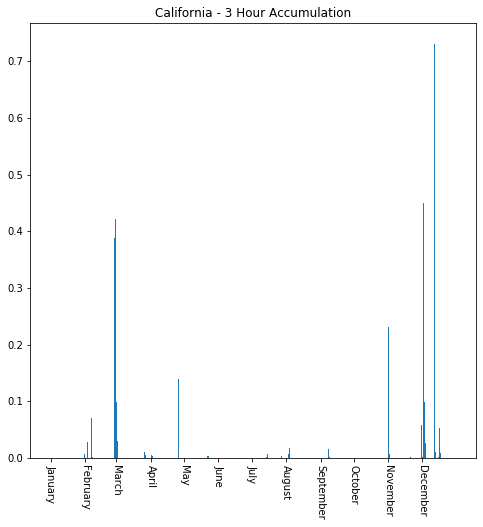

In [50]:
for blockgroup in ['chicago', 'california']:
    name = blockgroup[0].upper() + blockgroup[1:]
    
    data = pd.read_pickle('./hourly/precipitation_data/' + blockgroup + '.pkl')
    data = data.to_numpy()
    
    plt.figure(figsize=(8,8))
    plt.title(name + ' - 3 Hour Accumulation')
    width = 2.5
    plt.bar(date, data, width)
    plt.xticks(xticks, calendar.month_name[1:13], rotation=-90)
    plt.show()

## Daily Data 

In [51]:
date = [i for i in range(365)]
xticks = [1,31,59,90,120,151,181,212,243,273,304,334]

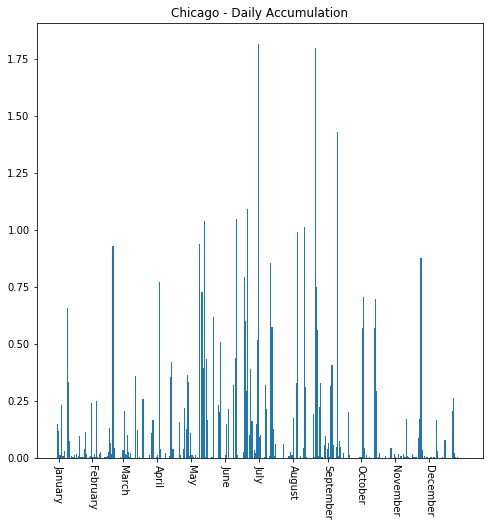

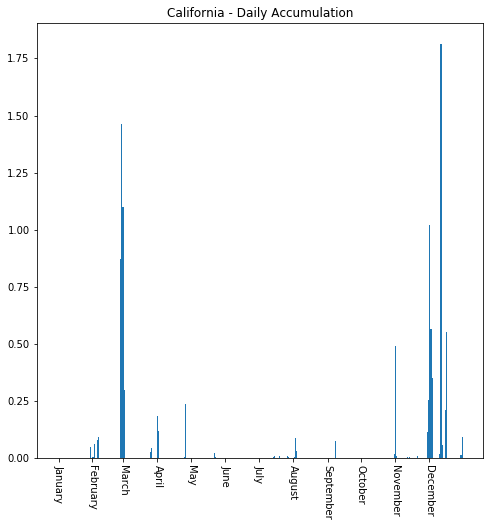

In [52]:
for blockgroup in ['chicago', 'california']:
    name = blockgroup[0].upper() + blockgroup[1:]
    
    data = pd.read_pickle('./daily/precipitation_data/' + blockgroup + '.pkl')
    data = data.to_numpy()
    
    plt.figure(figsize=(8,8))
    plt.title(name + ' - Daily Accumulation')
    width = 1.0
    plt.bar(date, data, width)
    plt.xticks(xticks, calendar.month_name[1:13], rotation=-90)
    plt.show()

# Data Validation

Ideally, the 3-hour accumulation data should sum across each day and be equal to the daily accumulation data. We will check if this is the case.

California
Total Daily Precipitation: 10.550279617332487
Total Hourly Precipitation: 10.550279658533885
Mean Δ: -1.1288054574813116e-10
Max Δ: 2.3466395562832254e-09
Min Δ: -3.7546232789509304e-08


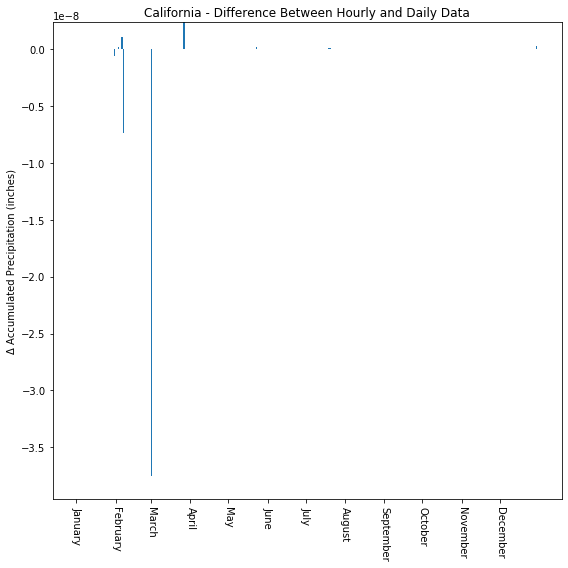

Chicago
Total Daily Precipitation: 39.33319043515053
Total Hourly Precipitation: 39.33319055844708
Mean Δ: -3.377987525184408e-10
Max Δ: 4.8601105584467064e-08
Min Δ: -4.341283188491474e-08


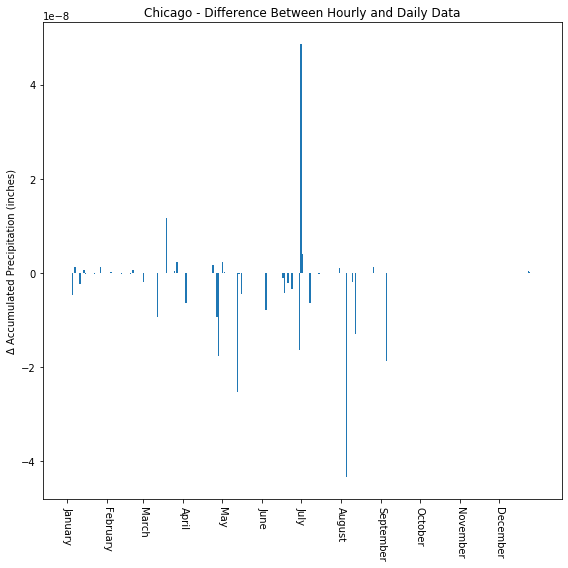

In [53]:
for blockgroup in ['california', 'chicago']:
    name = blockgroup[0].upper() + blockgroup[1:]
    print(name)
    
    hourly = pd.read_pickle('./hourly/precipitation_data/' + blockgroup + '.pkl')
    hourly_summed = hourly.groupby(((hourly.index-1) // 8) + 1).sum()
    daily = pd.read_pickle('./daily/precipitation_data/' + blockgroup + '.pkl')
    
    print('Total Daily Precipitation:', daily.sum())
    print('Total Hourly Precipitation:', hourly.sum())
    diff = daily - hourly_summed
    
    print('Mean Δ:', diff.mean())
    print('Max Δ:', diff.max())
    print('Min Δ:', diff.min())
    diff = diff.to_numpy().flatten()
    
    plt.figure(figsize=(8,8))
    plt.title(name + ' - Difference Between Hourly and Daily Data')

    date = [i for i in range(365)]
    xticks = [0,31,59,90,120,151,181,212,243,273,304,334]
    
    width = 1.0
    plt.bar(date, diff, width)
    plt.ylabel('Δ Accumulated Precipitation (inches)')
    plt.xticks(xticks, calendar.month_name[1:13], rotation=-90)
    plt.tight_layout()
    plt.show()

This shows that the hourly and daily data are virtually identical at the daily level.

# Formatting the Timeseries Data
We will format the timeseries precipitation data so it can be copy/pasted into a premade Chicago / California input file.

SWMM Timeseries Format:

[TIMESERIES]

Name    Date    Time   Value


## Hourly Data

In [65]:
out_dir = './hourly/timeseries/'
if not os.path.exists(out_dir):
    print('Making', out_dir)
    os.makedirs(out_dir)  

In [66]:
for bg in ['chicago', 'california']:    
    timeseries_name = 'NARR_3HR'

    frame = pd.read_pickle('./hourly/precipitation_data/' + bg + '.pkl').to_frame()
    
    date_rng = pd.date_range(start='1/1/2014', end='1/1/2015', freq='3H')
    date_rng = date_rng[:-1]  # Exclude 1/1/2015 00:00:00

    frame['date'] = date_rng.strftime('%m/%d/%Y')
    frame['time'] = date_rng.time.astype(str)
    frame['name'] = timeseries_name
    
    frame = frame[['name', 'date', 'time', bg]]
    data = frame.to_numpy()
    np.savetxt(out_dir + bg + '.txt', data, delimiter='\t', fmt='%s')

## Daily Data

In [68]:
out_dir = './daily/timeseries/'
if not os.path.exists(out_dir):
    print('Making', out_dir)
    os.makedirs(out_dir)  

In [70]:
for bg in ['chicago', 'california']:    
    timeseries_name = 'NARR_DAILY'

    frame = pd.read_pickle('./daily/precipitation_data/' + bg + '.pkl').to_frame()
    
    date_rng = pd.date_range(start='1/1/2014', end='1/1/2015', freq='1D')
    date_rng = date_rng[:-1]  # Exclude 1/1/2015
    
    frame['date'] = date_rng.strftime('%m/%d/%Y')
    frame['time'] = '00:00:00'
    frame['name'] = timeseries_name
    
    frame = frame[['name', 'date', 'time', frame.columns[0]]]
    data = frame.to_numpy()
    np.savetxt(out_dir + bg + '.txt', data, delimiter='\t', fmt='%s')

# Creating the Input File

We will create input files for the No Green Infrastructure scenario for both Chicago (170319800001) and California (060375508003).

The code is already created in create_input_file.py in the root of this repository.

I've included the input files used for the simulations in this notebook's folder.

In [ ]:
# TODO

# Running the Simulation

In [6]:
for sim_type in ['hourly', 'daily', 'prism']:
    input_files = glob.glob('./' + sim_type + '/simulation_files/*.inp')
    for file in input_files:
        sim = Simulation(file)
        sim.execute()


... SWMM Version 5.3.0.dev0
... Run Complete
... SWMM Version 5.3.0.dev0
... Run Complete
... SWMM Version 5.3.0.dev0
... Run Complete
... SWMM Version 5.3.0.dev0
... Run Complete
... SWMM Version 5.3.0.dev0
... Run Complete
... SWMM Version 5.3.0.dev0
... Run Complete

# Extracting the Simulation Data


In [8]:
for sim_type in ['hourly', 'daily', 'prism']:
    out_dir = './' + sim_type + '/extracted_simulation_data/'
    if not os.path.exists(out_dir):
        print('Making', out_dir)
        os.makedirs(out_dir)

Making ./hourly/extracted_simulation_data/
Making ./daily/extracted_simulation_data/
Making ./prism/extracted_simulation_data/


In [9]:
chicago = '170319800001'
california = '060375508003'

for blockgroup in ['chicago', 'california']:
    for sim_type in ['hourly', 'daily', 'prism']:
        
        # For fixing the Runoff data (divide by subcatch area)
        if blockgroup == 'chicago':
            area = 4933.82198249943
            geoid = '170319800001'
        else:
            area = 67.3855335000138
            geoid = '060375508003'
        
        
        output_file = glob.glob('./' + sim_type + '/simulation_files/' + geoid + '*.out')[0]
        extract_vars = [['system', 'Rainfall', 'Rainfall'],['system','Runoff','Runoff'],['system','Evaporation_infiltration','Evaporation_infiltration']]
        data = swmmtoolbox.extract(output_file, *extract_vars)
        
        data['system__Runoff'] = data['system__Runoff'].apply(lambda x: x / area)
        
        data.to_pickle('./' + sim_type + '/extracted_simulation_data/' + blockgroup + '.pkl')

/home/matas/anaconda3/envs/swmm/lib/python3.7/site-packages/swmmtoolbox/swmmtoolbox.py:800: FutureWarning: The join_axes-keyword is deprecated. Use .reindex or .reindex_like on the result to achieve the same functionality.
  result = pd.concat(jtsd, axis=1, join_axes=[jtsd[0].index])


## Data Comparison Plots

We will plot the Daily, Hourly, and PRISM data

In [16]:
out_dir = './plots/combined_plots/'
if not os.path.exists(out_dir):
    print('Making', out_dir)
    os.makedirs(out_dir)

Making ./plots/combined_plots/


chicago
./plots/combined_plots/chicago_system__Rainfall.svg


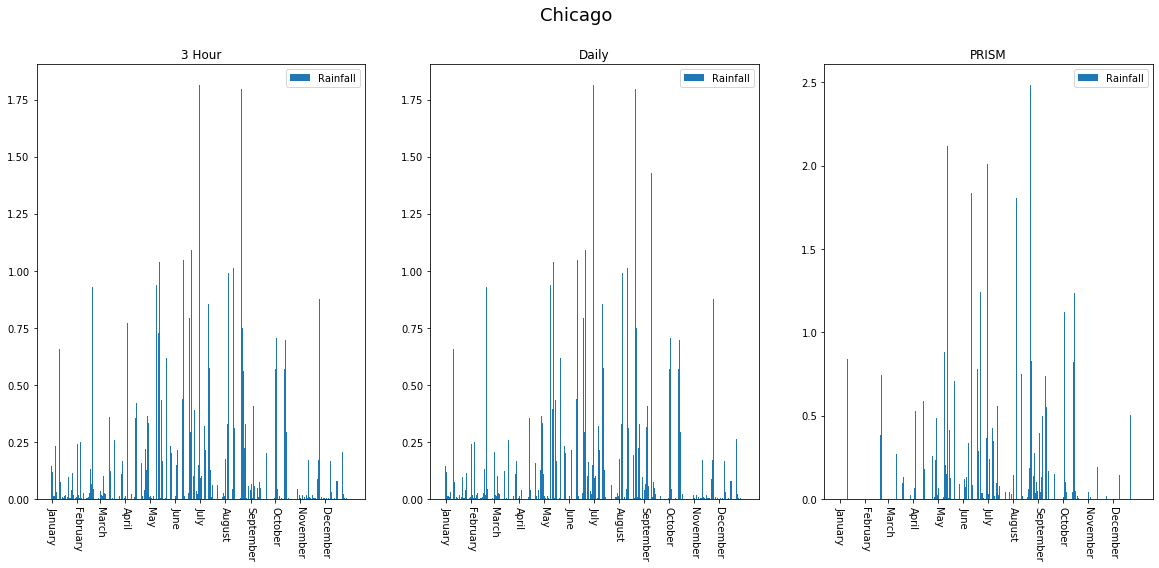

./plots/combined_plots/chicago_system__Evaporation_infiltration.svg


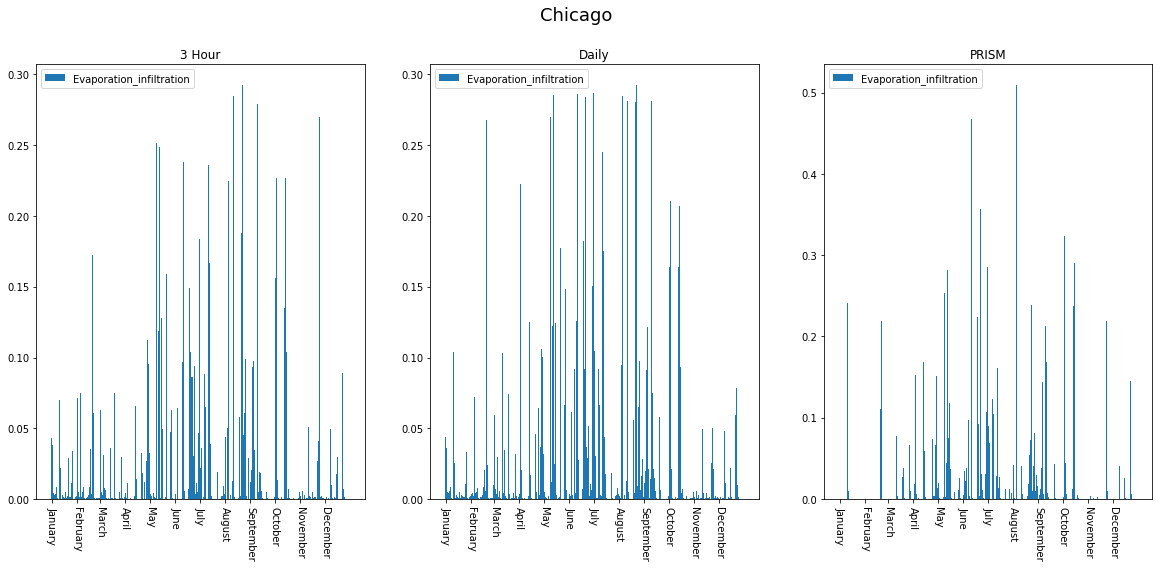

./plots/combined_plots/chicago_system__Runoff.svg


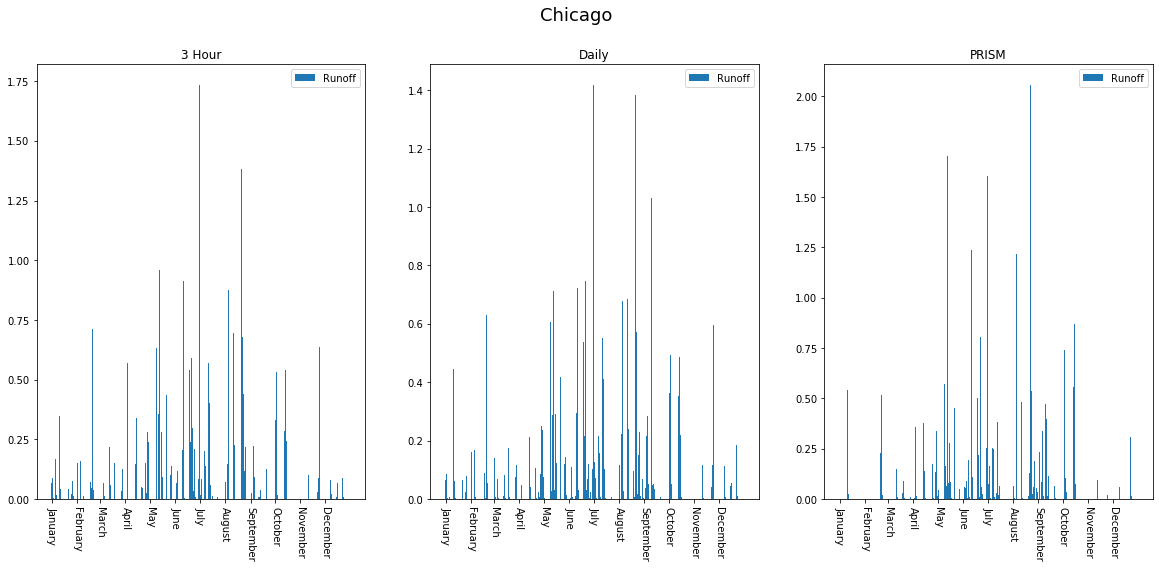

california
./plots/combined_plots/california_system__Rainfall.svg


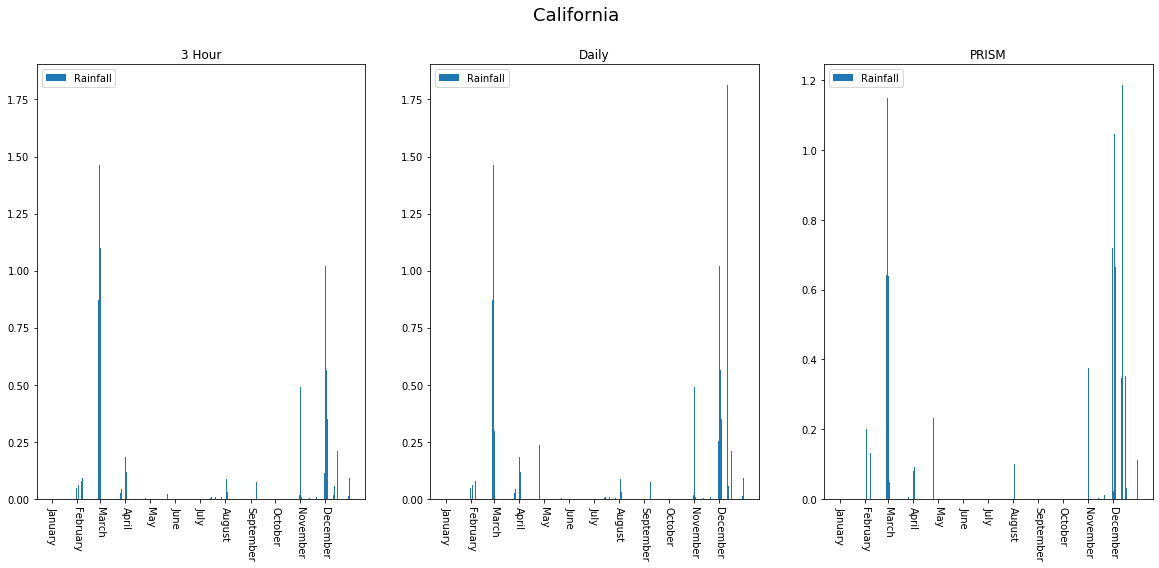

./plots/combined_plots/california_system__Evaporation_infiltration.svg


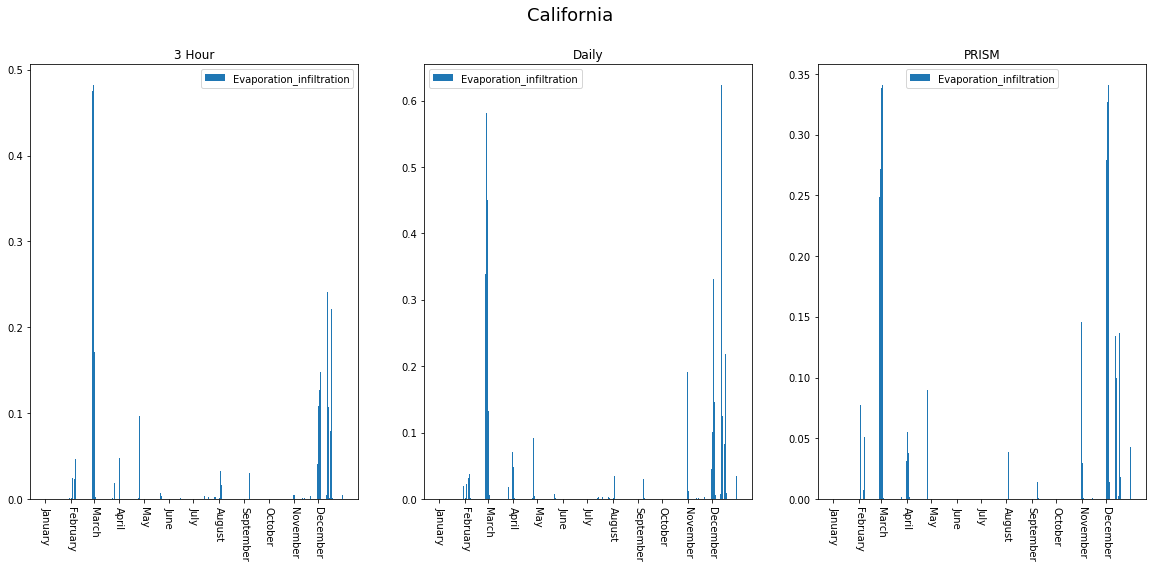

./plots/combined_plots/california_system__Runoff.svg


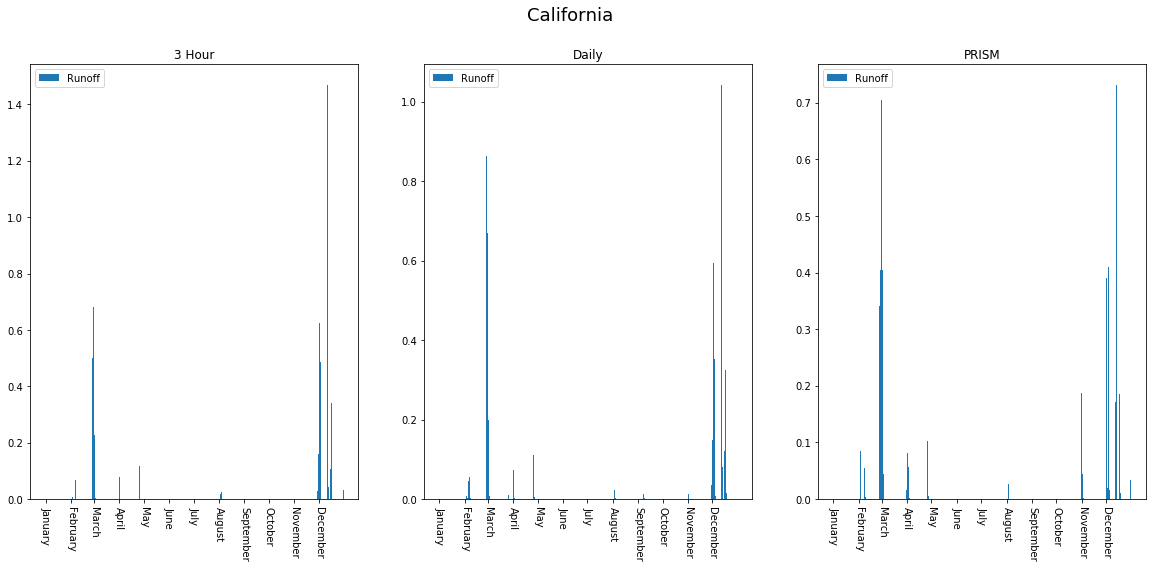

In [19]:
for bg in ['chicago', 'california']:    
    print(bg)
    name = bg[0].upper() + bg[1:]
    
    hour = pd.read_pickle('./hourly/extracted_simulation_data/' + bg + '.pkl').resample('d').sum()
    daily = pd.read_pickle('./daily/extracted_simulation_data/' + bg + '.pkl').resample('d').sum()
    prism = pd.read_pickle('./prism/extracted_simulation_data/' + bg + '.pkl').resample('d').sum()
    
    date = [i for i in range(365)]
    
    
    for data in ['system__Rainfall', 'system__Evaporation_infiltration', 'system__Runoff']:
        width = 1.0
        data_name = data[8:]
        
        fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(20, 8))

        fig.suptitle(name, fontsize=18)

        axes[0].set_title('3 Hour')
        axes[0].bar(date, hour[data], width, label=data_name)
        axes[0].set_xticks([0,31,59,90,120,151,181,212,243,273,304,334])
        axes[0].set_xticklabels(calendar.month_name[1:13], rotation=-90)
        axes[0].legend()

        axes[1].set_title('Daily')
        axes[1].bar(date, daily[data], width, label=data_name)
        axes[1].set_xticks([0,31,59,90,120,151,181,212,243,273,304,334])
        axes[1].set_xticklabels(calendar.month_name[1:13], rotation=-90)
        axes[1].legend()
        
        axes[2].set_title('PRISM')
        axes[2].bar(date, prism[data], width, label=data_name)
        axes[2].set_xticks([0,31,59,90,120,151,181,212,243,273,304,334])
        axes[2].set_xticklabels(calendar.month_name[1:13], rotation=-90)
        axes[2].legend()
    
        outfile = out_dir + bg + '_' + data + '.svg'
        print(outfile)
        
        plt.autoscale()
        plt.savefig(outfile)
        plt.show()
        
    

# Plotting Difference

We will plot the difference between hourly and daily simulation data for each variable (Rainfall, Runoff, Infiltatration/Evaporation).

In [21]:
out_dir = './plots/difference/'
if not os.path.exists(out_dir):
    print('Making', out_dir)
    os.makedirs(out_dir)

chicago
system__Rainfall
Max: 0.002101781778037548
Min: -1.4371471479535103e-07
Mean: 5.759214005991777e-06
system__Runoff
Max: 0.15757733492201953
Min: -0.31572336941137324
Mean: 0.00014277695200969677
system__Evaporation_infiltration
Max: 0.19761493935857288
Min: -0.07110393809853122
Mean: 0.003901756486905233


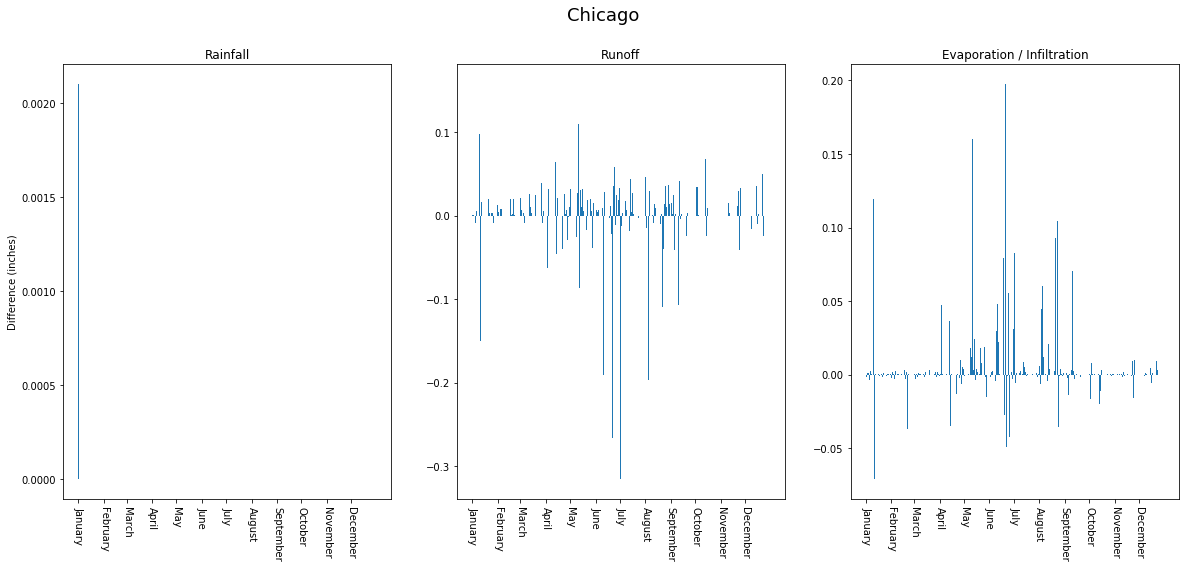

california
system__Rainfall
Max: 4.470348358154297e-08
Min: -1.3830140233039856e-07
Mean: -6.236613855485116e-10
system__Runoff
Max: 0.06305431577796627
Min: -0.42635972967629665
Mean: -0.0013915608473890205
system__Evaporation_infiltration
Max: 0.3822540359396953
Min: -0.03848380414274288
Mean: 0.0016743924531012503


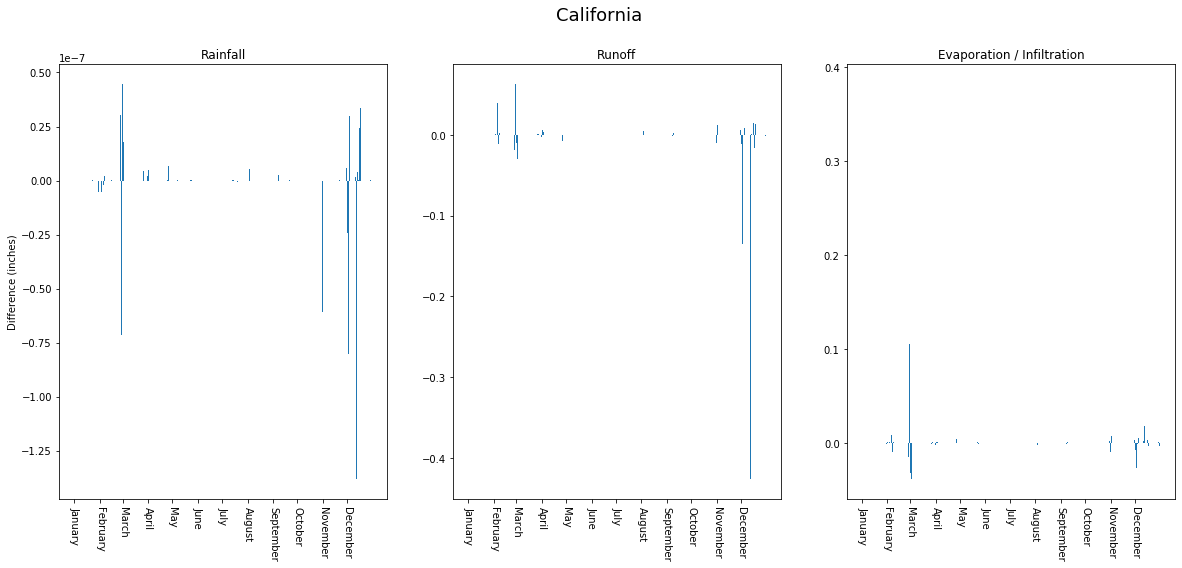

In [23]:
for bg in ['chicago', 'california']:
    print(bg)
    name = bg[0].upper() + bg[1:]
    
    hourly = pd.read_pickle('./hourly/extracted_simulation_data/' + bg + '.pkl').resample('d').sum()
    daily = pd.read_pickle('./daily/extracted_simulation_data/' + bg + '.pkl').resample('d').sum()
    
    difference = daily - hourly
    
    for variable in ['system__Rainfall', 'system__Runoff', 'system__Evaporation_infiltration']:
        print(variable)
        print('Max:', difference[variable].max())
        print('Min:', difference[variable].min())
        print('Mean:', difference[variable].mean())
        
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(20, 8))

    fig.suptitle(name, fontsize=18)

    axes[0].set_title('Rainfall')
    axes[0].set_ylabel('Difference (inches)')
    axes[0].bar(date, difference['system__Rainfall'], width, label='Rainfall')
    axes[0].set_xticks([0,31,59,90,120,151,181,212,243,273,304,334])
    axes[0].set_xticklabels(calendar.month_name[1:13], rotation=-90)

    axes[1].set_title('Runoff')
    axes[1].bar(date, difference['system__Runoff'], width, label='Runoff')
    axes[1].set_xticks([0,31,59,90,120,151,181,212,243,273,304,334])
    axes[1].set_xticklabels(calendar.month_name[1:13], rotation=-90)

    axes[2].set_title('Evaporation / Infiltration')
    axes[2].bar(date, difference['system__Evaporation_infiltration'], width, label='Evaporation_infiltration')
    axes[2].set_xticks([0,31,59,90,120,151,181,212,243,273,304,334])
    axes[2].set_xticklabels(calendar.month_name[1:13], rotation=-90)
    
    plt.autoscale()

    outfile = './plots/difference/' + bg + '_difference.svg'
    plt.savefig(outfile)    
    plt.show()
